# *Tetrahedra microFE pipeline - trabecular bone samples with a cylindrical shape*
From micro-CT image to tetrahedra-uFE model solution in Calculix

Created on:  23.05.2021 <br />
Last update: 02.05.2024 <br />

- By: [Gianluca Iori](https://github.com/gianthk), Martino Pani, [Gianluigi Crimi](https://github.com/gcrimi), Enrico Schileo, Fulvia Taddei, Giulia Fraterrigo, Alfonso Dario Santamaria 2024
- Data source: the dataset used in this example is part of the public collection of the Living Human Digital Library (LHDL) Project, a project financed by the European Commission (project number: [FP6-IST 026932](https://cordis.europa.eu/project/id/026932)). Human tissues in the LHDL project were collected according to the body donation program of Universitè Libre de Bruxelles (ULB), partner of the project. For info on the dataset see [here](http://projects.kmi.open.ac.uk/lhdl/).
- Code license: MIT
- Narrative license: CC-BY-NC-SA

---
# Aims
![](./../../fem_pipeline.png)
The example implements the following ciclope pipeline:
1. Crop, load and inspect microCT volume data
2. Image pre-processing
    - Apply Gaussian smooth (optional)
    - Resample the dataset (optional)
    - Segment bone tissue
    - Remove unconnected clusters of voxels
3. Mesh generation
    - Generate 3D Unstructured Grid mesh of tetrahedra
    - Generate high-resolution mesh of triangles of the model outer shell (optional for visualization)
4. Generate tetrahedra-FE model for simulation in CalculX or Abaqus from 3D Unstructured Grid mesh 
    - Linear, static analysis definition: uniaxial compression test
5. Launch simulation in Calculix. For info on the solver visit the [Calculix homepage](http://www.calculix.de/)
6. Convert Calculix output to .VTK for visualization in Paraview
7. Calculate apparent elastic modulus from reaction forces

---
## Notes on ciclope
* Tetrahedra meshes are generated with [pygalmesh](https://github.com/nschloe/pygalmesh) (a Python frontend to [CGAL](https://www.cgal.org/))
* High-resolution surface meshes for visualization are generated with the [PyMCubes](https://github.com/pmneila/PyMCubes) module.
* All mesh exports are performed with the [meshio](https://github.com/nschloe/meshio) module.
* **ciclope** handles the definition of material properties and FE analysis parameters (e.g. boundary conditions, simulation steps..) through separate template files. The folders [material_properties](https://github.com/gianthk/ciclope/tree/master/material_properties) and [input_templates](https://github.com/gianthk/ciclope/tree/master/input_templates) contain a library of template files that can be used to generate FE simulations.
  * Additional libraries of [CalculiX](https://github.com/calculix) examples and template files can be found [here](https://github.com/calculix/examples) and [here](https://github.com/calculix/mkraska)
___

---
# Computational workflow

## Configuration and imports

In [1]:
import sys
sys.path.append('./../../')

In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import mcubes
from scipy import ndimage, misc
import scipy.ndimage as ndi
from skimage.filters import threshold_otsu, gaussian
from skimage import measure, morphology
import meshio
import time
import math

from ciclope.utils.recon_utils import read_tiff_stack, plot_midplanes, touint8, sample_height
from ciclope.utils.preprocess import remove_unconnected, invert_images, convert_bmp_to_tiff, crop_and_resize_images
from ciclope.utils.postprocess import calculate_total_force, circular_masks_BVTV
from ciclope.utils.timer import Timer
from ciclope.core import tetraFE
import ciclope

C:\Users\utente\anaconda3\Lib\site-packages\ciclope\utils\postprocess.py:15: RuntimeWarning: ParaView.simple is required!
  warnings.warn("ParaView.simple is required!", RuntimeWarning)


Uncomment and run the following cell for visualizations using [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [3]:
#import vtk
#import itk
#from itkwidgets import view

[ccx2paraview](https://github.com/calculix/ccx2paraview) is needed for the postprocessing of results

In [4]:
from ccx2paraview import ccx2paraview

In [5]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

#### Crop and Load input data

ciclope takes inverted images as input, so in case you need to perform the following step.

In [6]:
# If you need invert the grayscale of the microCT images you can use this function
#bmp_folder = './../../test_data/LHDL/3155_D_4_bc/cylindrical_shape/bmp_folder'
#bmp_folder_INVERT = './../../test_data/LHDL/3155_D_4_bc/cylindrical_shape/bmp_folder_INVERT'
#invert_images(bmp_folder, bmp_folder_INVERT)

If you have images in .bmp format you can convert them to .tiff format otherwise go to the next step.

In [7]:
# If you need convert BMP images to TIFF format you can use this function 
#tiff_folder = './../../test_data/LHDL/3155_D_4_bc/cylindrical_shape/tiff_folder'
#tiff_folder = convert_bmp_to_tiff(bmp_folder_INVERT, tiff_folder)

Next perform the circular cropping and resizing of the images.

In [8]:
# Circular cropping
input_folder = './../../test_data/LHDL/3155_D_4_bc/cropped'
output_folder = input_folder + '_cyl'

diameter_mm = 3.5 # [mm] Set the diameter here

# Crop and resize images
crop_and_resize_images(input_folder, output_folder, diameter_mm)

In [9]:
input_file = output_folder + '/3155_D_4_bc_0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Lab|LTM@IOR Bologna|
|Sample|Human trabecular bone with a cylindrical shape|
|Voxel size|19.5 micron|
|Preliminary operations| cropped to 200x200x200 (4mm side)|

Read the input data and define an array of the voxelsize

In [10]:
data_3D = read_tiff_stack(input_file)
vs = np.ones(3)*19.5e-3 # [mm]

Inspect the dataset

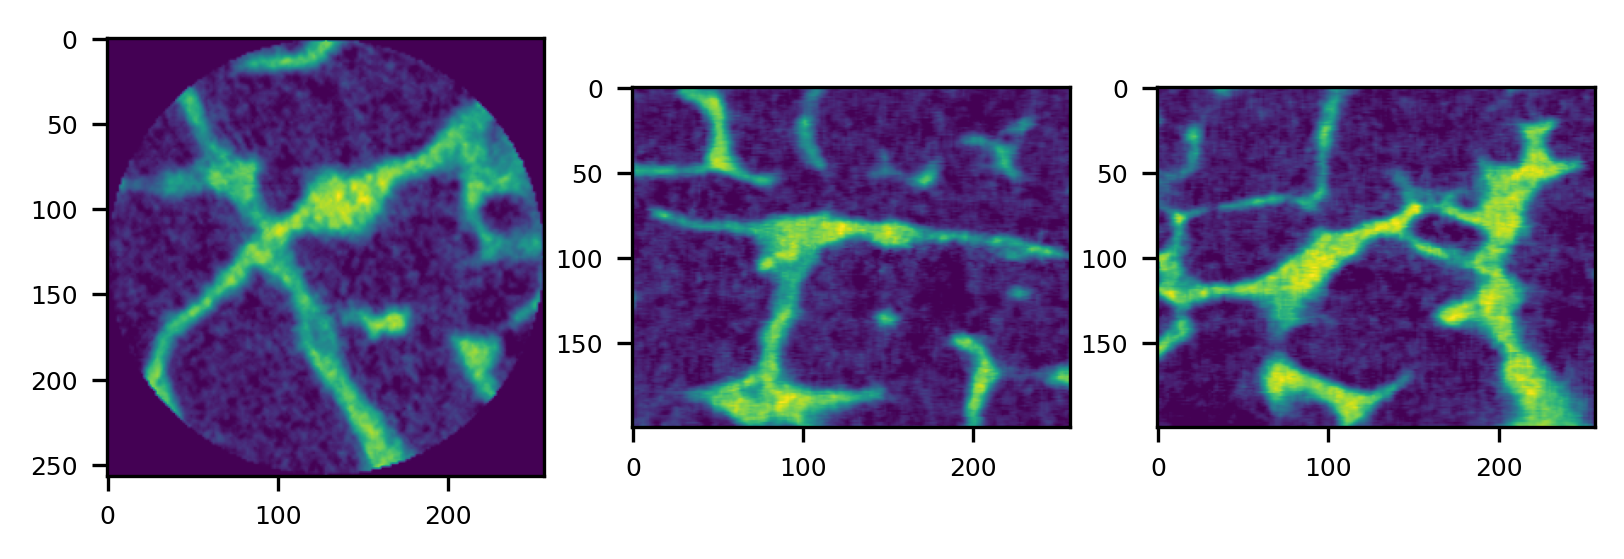

In [11]:
plot_midplanes(data_3D)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [12]:
#viewer = view(data_3D, ui_collapsed=True)
#viewer.interpolation = False

Launch the itk viewer

In [13]:
#viewer

## Pre-processing
### Gaussian smooth

In [14]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

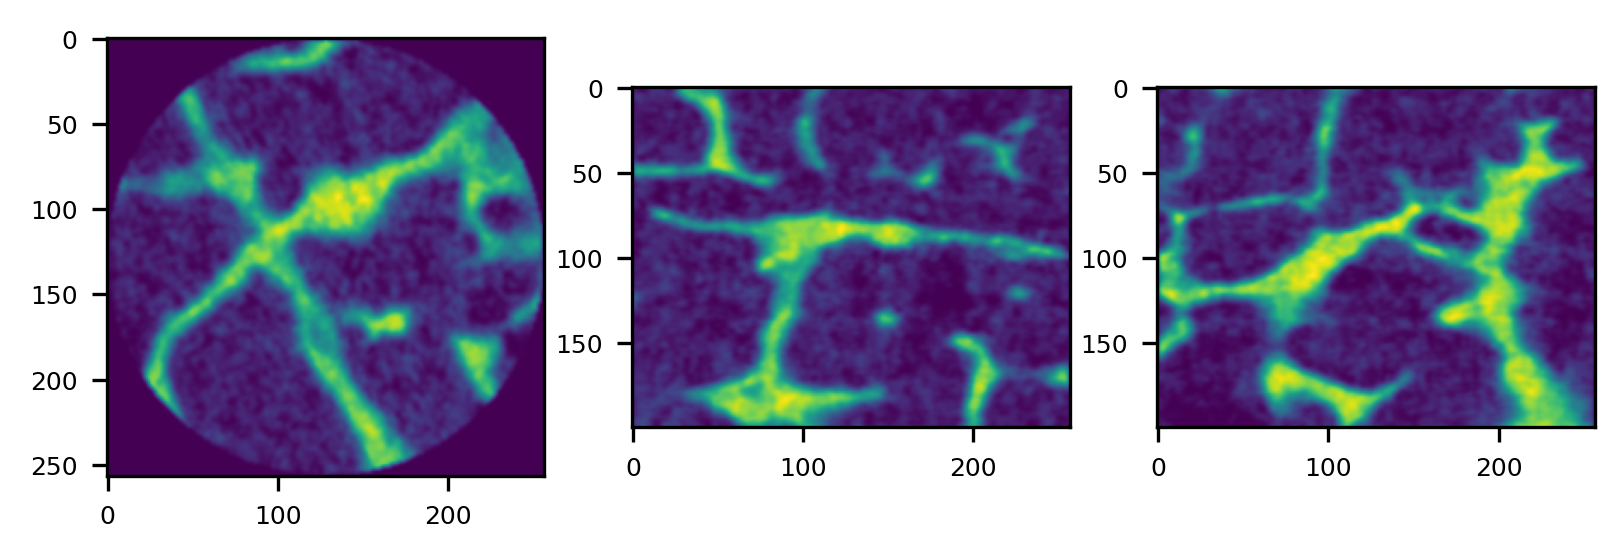

In [15]:
plot_midplanes(data_3D)
plt.show()

### Resize (optional)

In [16]:
resampling = 2

# resize the 3D data using spline interpolation of order 2
data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
vs = vs * resampling

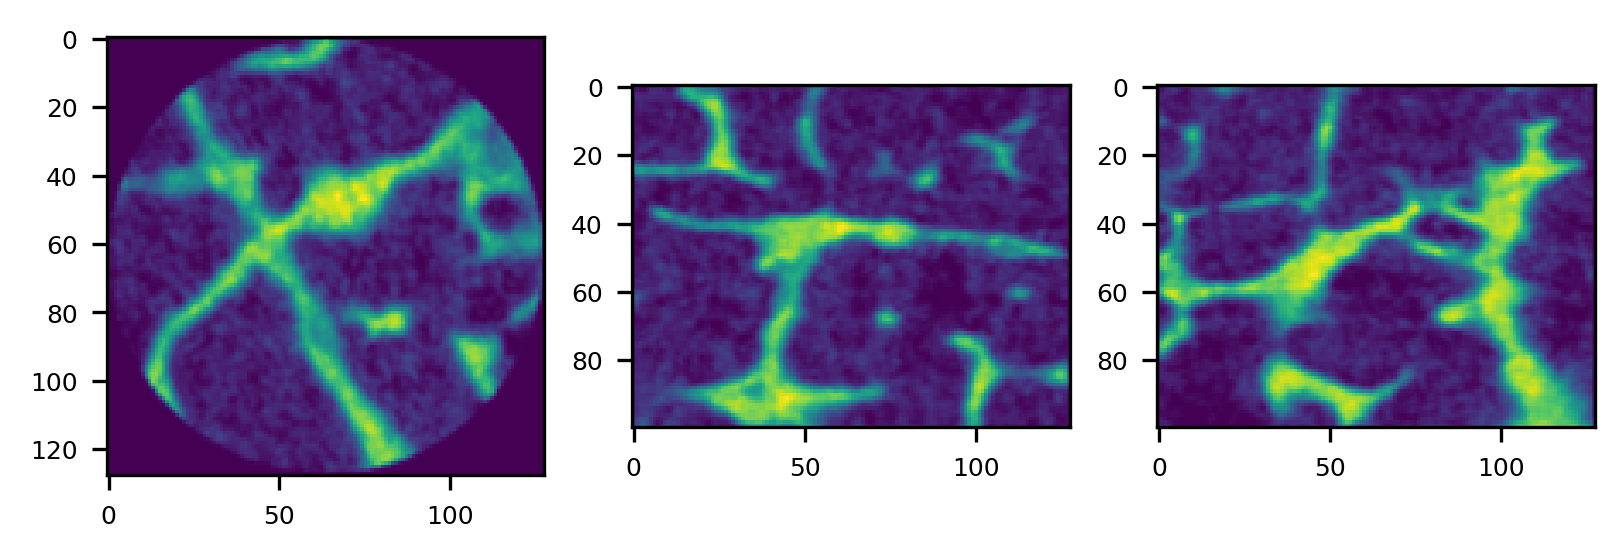

In [17]:
# Inspect again the dataset
plot_midplanes(data_3D)
plt.show()

### Thresholding
Use Otsu's method

In [18]:
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 75.93743921186032


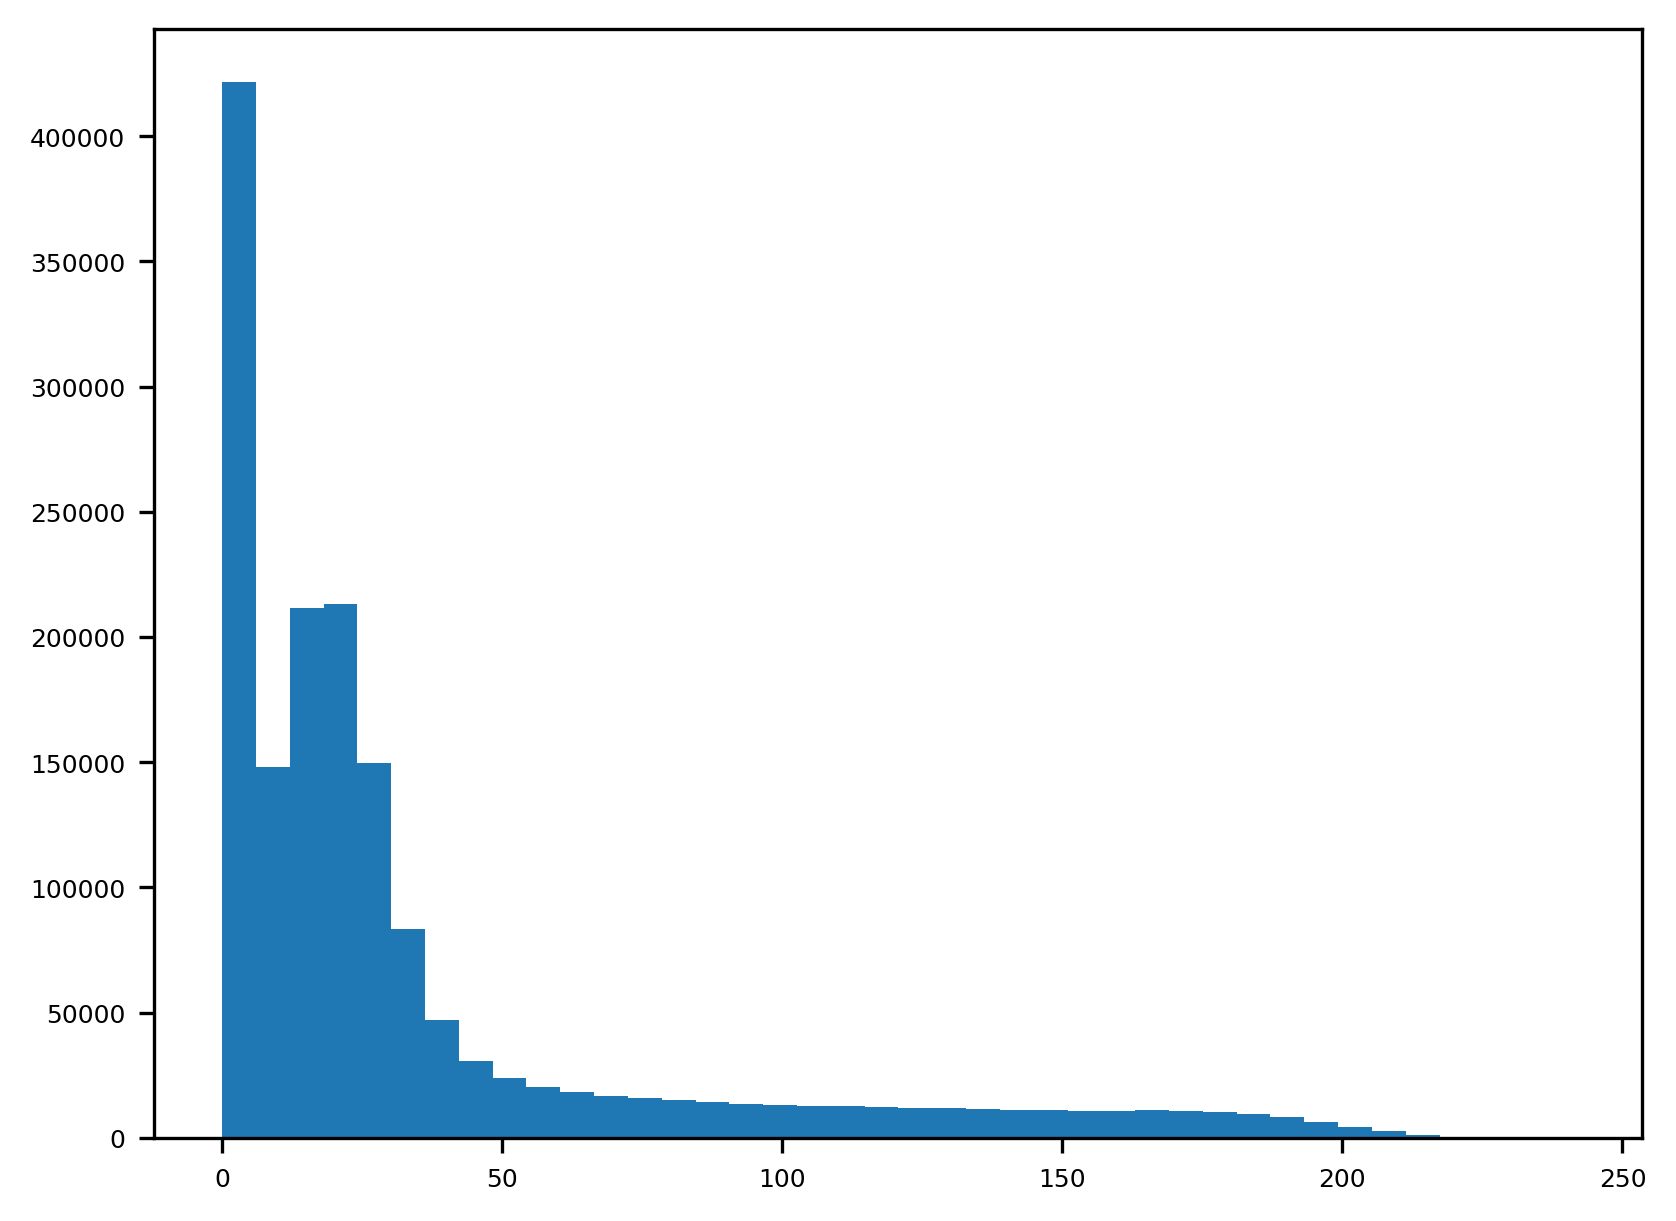

In [19]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

Apply single global threshold obtained from comparison with histology

In [20]:
#BW = data_3D > T 
BW = data_3D > 63 #by comparison with histology

Have a look at the binarized dataset

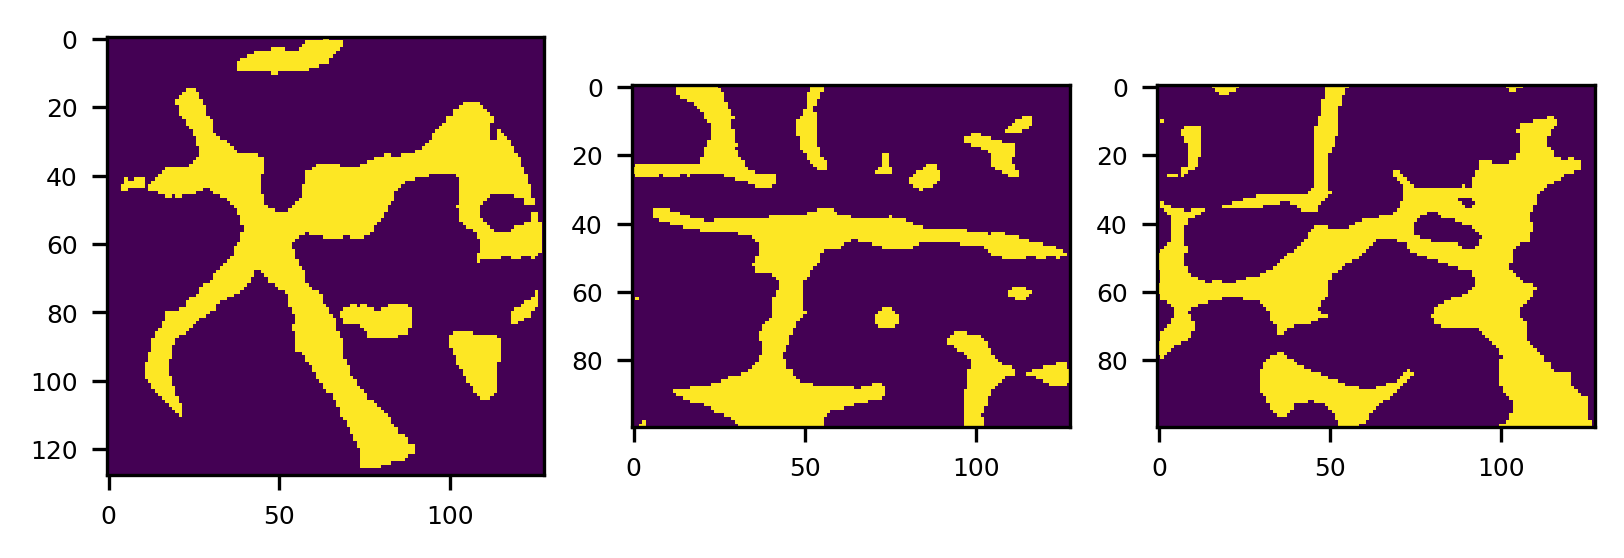

In [21]:
plot_midplanes(BW)
plt.show()

### Morphological close of binary image (optional)

Assessing the impact of morphological.ball before use

In [22]:
#BW = morphology.closing(BW, morphology.ball(3))

In [23]:
#plot_midplanes(BW)
#plt.show()

### Detect largest isolated cluster of voxels
The procedure is described by the following 3 steps:
1. Label the BW 3D image

In [24]:
# [labels, n_labels] = measure.label(BW, None, True, 1) # 1 connectivity hop

2. Count the occurrences of each label

In [25]:
# occurrences = np.bincount(labels.reshape(labels.size))

3. Find the largest unconnected label

In [26]:
# largest_label_id = occurrences[1:].argmax()+1
# L = labels == largest_label_id

You can do the same using the function `remove_unconnected` contained in `ciclope.utils.preprocess`

Removal of unconnected bone region

In [27]:
L = remove_unconnected(BW)

Inspect dataset

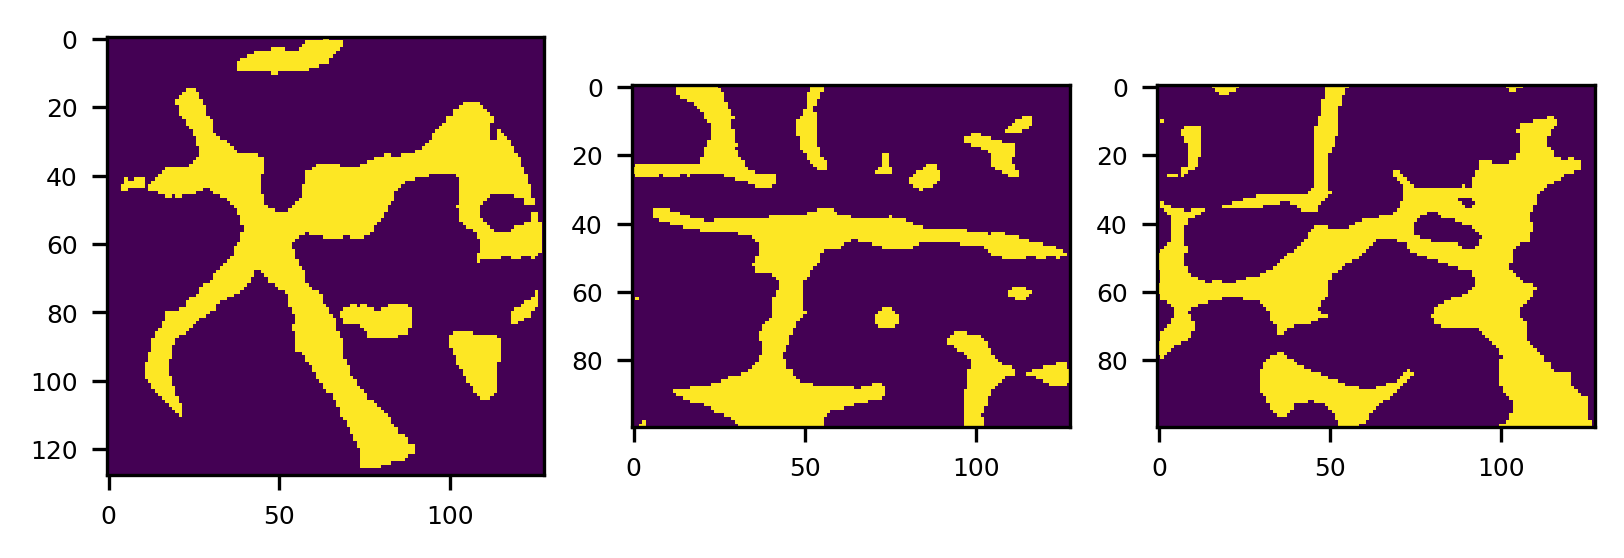

In [28]:
plot_midplanes(L)
plt.show()

## Shell mesh for visualization
**Create a mesh of triangles of the external bone surface (optional)**
Warning: this step is computationally expensive. Only useful for 3D rendering of the bone architecture.
1. Uncomment the following cell to create a shell mesh of triangles

In [29]:
#vertices, triangles, mesh = ciclope.tetraFE.shell_mesh(L, method='pymcubes')

2. Uncomment the following two cells to write the mesh as a VTK file with [meshio](https://github.com/nschloe/meshio)

In [30]:
#filename_shellmesh_out = './../../test_data/LHDL/3155_D_4_bc/3155_D_4_bc_shellmesh.vtk'

In [31]:
#meshio.write_points_cells(filename_shellmesh_out, vertices.tolist(), [("triangle", triangles.tolist())])

Visualize the mesh with itkwidgtes

In [32]:
#import vtk
#import itk
#from itkwidgets import view

In [33]:
#reader = vtk.vtkUnstructuredGridReader()
#reader.SetFileName(filename_shellmesh_out)
#reader.Update()
#grid = reader.GetOutput()

In [34]:
#view(geometries=grid)

### Create tetrahedra mesh
Volume meshing using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [35]:
filename_mesh_out = "./../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc-TETRAMESH_cyl.vtk"

This is the `pygalmesh` function call

In [36]:
# import pygalmesh
# mesh = pygalmesh.generate_from_array(np.transpose(L, [2, 1, 0]).astype('uint8'), tuple(vs), max_facet_distance=1.2*min(vs), max_cell_circumradius=5*1.2*min(vs))

Alternatively use the method `ciclope.core.tetraFE.cgal_mesh`

Reduce `mesh_size_factor` (keeping it small for fast execute)

In [37]:
mesh_size_factor = 1.5

In [38]:
a = 2

In [39]:
with Timer():
    mesh = tetraFE.cgal_mesh(L, vs, 'tetra', mesh_size_factor*min(vs), a*mesh_size_factor*min(vs))

Run time: 0 hours, 0 minutes, 16 seconds


In [40]:
print(mesh)

<meshio mesh object>
  Number of points: 12586
  Number of cells:
    tetra: 43533
  Point data: medit:ref
  Cell data: medit:ref


Uncomment the following to write the mesh of tetrahedra to disk

In [41]:
mesh.write(filename_mesh_out)

Visualize the mesh with itkwidgtes

In [42]:
#reader = vtk.vtkUnstructuredGridReader()
#reader.SetFileName(filename_mesh_out)
#reader.Update()
#grid = reader.GetOutput()

In [43]:
#view(geometries=grid)

## Write Abaqus input FE files
### Generate tetrahedra-FE model with constant material properties
The method `ciclope.tetraFE.mesh2tetrafe` assumes that the material property definition is contained in the FE analysis `.INP` template file.

In [44]:
input_template = "./../../input_templates/tmp_example01_comp_static_bone.inp"

Inspect input template file

In [45]:
!cat {input_template} # on linux
#!type ..\..\input_templates\tmp_example01_comp_static_bone.inp # on Win

** ----------------------------------------------------
** Material definition:
*MATERIAL, NAME=BONE
*ELASTIC
18000, 0.3, 0
*SOLID SECTION, ELSET=SET1, MATERIAL=BONE
** ---------------------------------------------------
** Analysis definition. The Step module defines the analysis steps and associated output requests.
** More info at:
** https://abaqus-docs.mit.edu/2017/English/SIMACAECAERefMap/simacae-m-Sim-sb.htm#simacae-m-Sim-sb
** ---------------------------------------------------
*STEP
*STATIC
** All displacements fixed at bottom:
*BOUNDARY
NODES_Z0, 1, 3, 0.0
** Vertical displacement imposed at top:
*BOUNDARY
NODES_Z1, 3, 3, -0.04
** ---------------------------------------------------
** Output request:
*NODE FILE, OUTPUT=2D
U
*NODE PRINT, TOTALS=ONLY, NSET=NODES_Z0
RF
*EL FILE, OUTPUT=2D
S, E
*END STEP


cat: '#': No such file or directory
cat: on: No such file or directory
cat: linux: No such file or directory


In [46]:
filename_out = "./../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_TetraFE_cyl.inp"

Generate **CalculiX** input file with the `tetraFE.mesh2tetrafe` method

In [47]:
with Timer():
    ciclope.core.tetraFE.mesh2tetrafe(mesh, input_template, filename_out)

Run time: 0 hours, 0 minutes, 0 seconds


## Solve FE model in calculix
The following section assumes that you have the Calculix solver installed and accessible with the command `ccx_2.17` or for multithread option `ccx_2.17_MT`. <br />
The multithread option in CalculiX is activated by defining the number of threads (default=1) used for the calculation.<br />
This is done by setting the env variable *OMP_NUM_THREADS* with:
`export OMP_NUM_THREADS=8`

In [48]:
#!export OMP_NUM_THREADS=8; ccx_2.17_MT "./../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_TetraFE_cyl"

---
## Post-processing of FE results
### Convert Calculix output to Paraview
The following sections assume that you have **ccx2paraview** and **Paraview** installed and working.<br /> For more info visit: <br />
- [https://www.paraview.org/](https://www.paraview.org/)
- [https://github.com/calculix/ccx2paraview](https://github.com/calculix/ccx2paraview)

In [49]:
with Timer():
    filename_out_base, ext_out = os.path.splitext(filename_out)
    ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run() #create the file tetraFe.vtk

Run time: 0 hours, 0 minutes, 1 seconds


#### Visualize results in Paraview

In [50]:
#!paraview {filename_out_base + '.vtk'}

![UMAG_displacements](./../../test_data/LHDL/3155_D_4_bc/results/LHDL_tetraFE_cyl_UMAG.png)

#### Post-process FE analysis results
Display the CalculiX FE output `.DAT` file containing the sum of reaction forces:

In [51]:
filename_dat = filename_out_base + '.dat'

In [52]:
!cat {filename_dat}


 total force (fx,fy,fz) for set NODES_Z0 and time  0.1000000E+01

        2.875034E-12  6.327577E-13  2.246599E+02


### Apparent elastic modulus
`E_app = (F_tot / A) / epsilon`

In [53]:
input_folder = './../../test_data/LHDL/3155_D_4_bc/cropped'
vs = 0.0195
height_mm = sample_height(input_folder, vs)
print(f"The sample height is: {height_mm} mm")

The sample height is: 3.9 mm


In [54]:
pigreco = math.pi
diameter_pixel = round(diameter_mm/vs)
displacement = 0.04

A = pigreco * ((diameter_mm)/2)**2 # [mm^2]
epsilon = displacement/(height_mm)

In [55]:
F_tot = calculate_total_force(filename_dat)

if F_tot is not None:
    print(f"F_tot = {F_tot} N")

F_tot = 224.6599 N


In [56]:
E = (F_tot/A)/epsilon
print(f"E = {E:.2f} MPa")

E = 2276.69 MPa


Bone volume fraction

In [57]:
circular_masks, BVTV = circular_masks_BVTV(L, diameter_mm, vs)
print(f"BVTV: {BVTV * 100:.2f}%")

BVTV: 17.14%


---
# Dependencies

In [ ]:
import watermark

In [ ]:
%load_ext watermark

%watermark
%watermark --iversions

---
# Acknowledgements
- This notebook was developed within [Building the Jupyter Community in MSK Imaging Research](https://github.com/JCMSK/2022_JCW), a Jupyter Community Workshop sponsored by [NUMFocus](https://numfocus.org/)